In [19]:
import math

from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session

In [20]:
# Add your token below
service = QiskitRuntimeService(channel="ibm_quantum")

In [21]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    for target in marked_states:
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

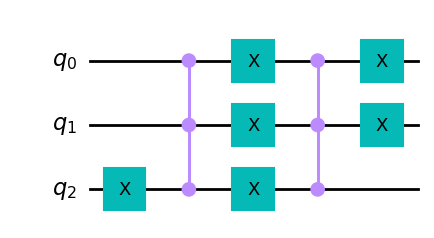

In [22]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw("mpl")

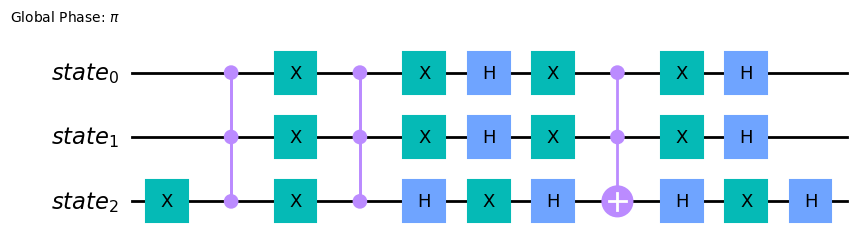

In [23]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw("mpl")

In [24]:
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**grover_op.num_qubits / len(marked_states))
)

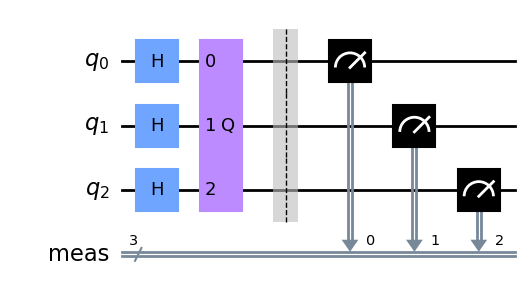

In [25]:
qc = QuantumCircuit(grover_op.num_qubits)

# put all Qubits into superposition by applying Hadamard
qc.h(range(grover_op.num_qubits))

qc.compose(grover_op.power(optimal_num_iterations), inplace=True)

qc.measure_all()
qc.draw("mpl")

In [26]:
# Amplitude Amplification

backend = service.least_busy(simulator=False, operational=True)
backend.name

'ibm_brisbane'

In [27]:
session = Session(backend=backend)
real_sampler = Sampler(session=session)

In [ ]:
real_dist = real_sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

In [ ]:
plot_distribution(real_dist.binary_probabilities())

In [ ]:
session.close()